## RQ1 Forest Definition Comparisons 

[Add description]

Steps
1. Analyse & Compare FNF maps for Natura 2000 areas 
    1. Generate zonal statistics
    2. Format into geodataframes
    3. Calculations
    4. ~~Visualisations~~
2. Create *Forest Presence/Absence Consensus Map* (Sexton et al 2016 approach)
3. Analyse Consensus Map for Natura 2000 areas
    1. Generate zonal statistics
    2. Format into geodataframe
    3. Calculations
    4. ~~Visualisations~~

4. Germany analysis?
**NOTE: for now I'm only doing statistics and comparisons for the Natura 2000 areas, but there is data for all of Germany - so I could do some similar calculations and comparisons for all of Germany. Rather than using zonal statistics, here I would just need to calculate the count and sum for each whole FNF raster. Alternatively, I could do zonal statistics using the CORINE footprint area.**


In [2]:
# SETUP

# Note: this .ipynb file depends on files & folder structures created in rq1_step1_data_prep.ipynb 
# and rq1_step2_fao_forest.ipynb

# Import packages
import os
import subprocess
import pickle
import pandas as pd
import matplotlib.pyplot as plt 

from rasterstats import zonal_stats
import geopandas as gpd
from shapely.geometry import shape

# Create required directories if they don't already exist
# Note: these directories are ignored in git
path_list = ["./outputs/figures"]

for path in path_list:
  if not os.path.exists(path):
    os.mkdir(path)
    print("Folder %s created!" % path)
  else:
    print("Folder %s already exists" % path)

# Store gdal.py paths
gdal_calc = "./thesis_env_conda/Lib/site-packages/GDAL-3.10.1-py3.12-win-amd64.egg-info/scripts/gdal_calc.py"

Folder ./outputs/figures already exists


### Step 1: Analyse & Compare FNF Maps for Natura 2000 areas

Generally, I will calculate the count (total pixels) and sum (total forest pixels) for the Natura 2000 areas for each FNF map. I will then perform additional calculations to generate results across all areas, and compare results across the different FNF maps.

#### Step 1.1: Generate zonal statistics

Zonal stats (sum and count) per geometry for each FNF map

Convert each to a feature collection

In [9]:
# 1.1: FNF NATURA ZONAL STATS 
# EACH OUTPUT TAKES ABUOT 30 MIN (3 HOURS TOTAL)

# Store paths to the FNF maps
esa_FNF = "./outputs/esa_lccs_class_3035_DE_5m_2018_FNF.tif"
jaxa_FNF = "./outputs/jaxa_FNF_3035_DE_5m_2018_FNF.tif"
corine_FNF = "./outputs/U2018_CLC2018_V2020_3035_DE_5m_2018_FNF.tif"
ger_lulc_FNF = "./outputs/clc5_class3xx_3035_DE_5m_2018_FNF.tif"
hansen_FNF = "./outputs/hansen_60cover_2018_3035_DE_5m_2018_FNF.tif"
fao_FNF = "./outputs/fao_approx_3035_DE_5m_2018_FNF.tif"

# Load the German Natura 2000 areas (w/o "RELEASE_DA" column as this causes problems later)
natura = gpd.read_file("./outputs/natura2000_3035_DE.shp", 
                       columns=["SITECODE", "SITENAME", "MS", "SITETYPE"])

# Calculate the sum & count for each Natura 2000 geometry, for each FNF map 
# Keep the geometeries by outputting in geojson format
esaFNF_natura_stats = zonal_stats(natura, esa_FNF,
                                  stats=['sum', 'count'],
                                  geojson_out=True)

jaxaFNF_natura_stats = zonal_stats(natura, jaxa_FNF,
                                  stats=['sum', 'count'],
                                  geojson_out=True)

corineFNF_natura_stats = zonal_stats(natura, corine_FNF,
                                  stats=['sum', 'count'],
                                  geojson_out=True)  

gerlulcFNF_natura_stats = zonal_stats(natura, ger_lulc_FNF,
                                  stats=['sum', 'count'],
                                  geojson_out=True)

hansenFNF_natura_stats = zonal_stats(natura, hansen_FNF,
                                  stats=['sum', 'count'],
                                  geojson_out=True)

faoFNF_natura_stats = zonal_stats(natura, fao_FNF,
                                  stats=['sum', 'count'],
                                  geojson_out=True)

# Convert results to feature collections
esaFNF_natura_stats_fc = {"type": "FeatureCollection","features": esaFNF_natura_stats}
jaxaFNF_natura_stats_fc = {"type": "FeatureCollection","features": jaxaFNF_natura_stats}
corineFNF_natura_stats_fc = {"type": "FeatureCollection","features": corineFNF_natura_stats}
gerlulcFNF_natura_stats_fc = {"type": "FeatureCollection","features": gerlulcFNF_natura_stats}
hansenFNF_natura_stats_fc = {"type": "FeatureCollection","features": hansenFNF_natura_stats}
faoFNF_natura_stats_fc = {"type": "FeatureCollection","features": faoFNF_natura_stats}


#### Step 1.2: Format into geodataframes

Use some functions to extract the zonal statistics data (which is in geojson format) into lists and then convert these lists to geodataframes (geopandas).

At this point, I also save the outputs using pickle.dump() so that step 1.1 doesn't need to be run every time. 

In [10]:
# 1.2: EXTRACT INTO LISTS

# Extract features from the feature collections
esa_features = esaFNF_natura_stats_fc["features"]
jaxa_features = jaxaFNF_natura_stats_fc["features"]
corine_features = corineFNF_natura_stats_fc["features"]
gerlulc_features = gerlulcFNF_natura_stats_fc["features"]
hansen_features = hansenFNF_natura_stats_fc["features"]
fao_features = faoFNF_natura_stats_fc["features"]

# Create empty lists for the properties I'm interested in
esa_codes, esa_names, esa_types, esa_counts, esa_sums, esa_geoms = ([] for i in range(6))
jaxa_codes, jaxa_names, jaxa_types, jaxa_counts, jaxa_sums, jaxa_geoms = ([] for i in range(6))
cor_codes, cor_names, cor_types, cor_counts, cor_sums, cor_geoms = ([] for i in range(6))
ger_codes, ger_names, ger_types, ger_counts, ger_sums, ger_geoms = ([] for i in range(6))
hans_codes, hans_names, hans_types, hans_counts, hans_sums, hans_geoms = ([] for i in range(6))
fao_codes, fao_names, fao_types, fao_counts, fao_sums, fao_geoms = ([] for i in range(6))

# Create a function for filling lists (extracting according to json format)
def fill_lists(input_features, code_list, name_list, type_list, count_list, sum_list, geom_list):
    for row in input_features:
        code_list.append(row['properties']['SITECODE'])
        name_list.append(row['properties']['SITENAME'])
        type_list.append(row['properties']['SITETYPE'])
        count_list.append(row['properties']['count'])
        sum_list.append(row['properties']['sum'])
        geom_list.append(row['geometry'])

# Use the function to fill the lists
fill_lists(esa_features, esa_codes, esa_names, esa_types, esa_counts, esa_sums, esa_geoms)
fill_lists(jaxa_features, jaxa_codes, jaxa_names, jaxa_types, jaxa_counts, jaxa_sums, jaxa_geoms)
fill_lists(corine_features, cor_codes, cor_names, cor_types, cor_counts, cor_sums, cor_geoms)
fill_lists(gerlulc_features, ger_codes, ger_names, ger_types, ger_counts, ger_sums, ger_geoms)
fill_lists(hansen_features, hans_codes, hans_names, hans_types, hans_counts, hans_sums, hans_geoms)
fill_lists(fao_features, fao_codes, fao_names, fao_types, fao_counts, fao_sums, fao_geoms)


In [11]:
# 1.2: CREATE GDFS 

# Create a function for creating the geodataframes from the lists
def create_stats_gdf(code_list, name_list, type_list, count_list, sum_list, geom_list):
    gdf = gpd.GeoDataFrame({'site_code' : code_list,
                            'site_name' : name_list,
                            'site_type' : type_list,
                            'total_pixel_count' : count_list,
                            'forest_pixel_sum' : sum_list,
                            'geometry' : [shape(i) for i in geom_list] # Convert geometries to correct format
                            })
    return gdf

# Use the function to create the gdfs
esa_FNF_natura_stats_gdf = create_stats_gdf(esa_codes, esa_names, esa_types,  
                                            esa_counts, esa_sums, esa_geoms)
jaxa_FNF_natura_stats_gdf = create_stats_gdf(jaxa_codes, jaxa_names, jaxa_types,
                                             jaxa_counts, jaxa_sums, jaxa_geoms)
corine_FNF_natura_stats_gdf = create_stats_gdf(cor_codes, cor_names, cor_types,  
                                               cor_counts, cor_sums, cor_geoms)
gerlulc_FNF_natura_stats_gdf = create_stats_gdf(ger_codes, ger_names, ger_types,  
                                                ger_counts, ger_sums, ger_geoms)
hansen_FNF_natura_stats_gdf = create_stats_gdf(hans_codes, hans_names, hans_types, 
                                               hans_counts, hans_sums, hans_geoms)
fao_FNF_natura_stats_gdf = create_stats_gdf(fao_codes, fao_names, fao_types, 
                                            fao_counts, fao_sums, fao_geoms)



In [12]:
# 1.2: SAVE GDFS 

# Save the geodataframe (so preceeding steps only need to be run once)
pickle.dump(esa_FNF_natura_stats_gdf, open("./processing/esaFNF_natura_stats.p", "wb"))
pickle.dump(jaxa_FNF_natura_stats_gdf, open("./processing/jaxaFNF_natura_stats.p", "wb"))
pickle.dump(corine_FNF_natura_stats_gdf, open("./processing/corineFNF_natura_stats.p", "wb"))
pickle.dump(gerlulc_FNF_natura_stats_gdf, open("./processing/gerlulcFNF_natura_stats.p", "wb"))
pickle.dump(hansen_FNF_natura_stats_gdf, open("./processing/hansenFNF_natura_stats.p", "wb"))
pickle.dump(fao_FNF_natura_stats_gdf, open("./processing/faoFNF_natura_stats.p", "wb"))

In [13]:
# 1.2: LOAD GDFS 
# START FROM HERE WHEN RETURNING TO SCRIPT

# Load the zonal stats outputs 
esa_FNF_natura_stats_gdf = pickle.load(open("./processing/esaFNF_natura_stats.p", "rb"))
jaxa_FNF_natura_stats_gdf = pickle.load(open("./processing/jaxaFNF_natura_stats.p", "rb"))
corine_FNF_natura_stats_gdf = pickle.load(open("./processing/corineFNF_natura_stats.p", "rb"))
gerlulc_FNF_natura_stats_gdf = pickle.load(open("./processing/gerlulcFNF_natura_stats.p", "rb"))
hansen_FNF_natura_stats_gdf = pickle.load(open("./processing/hansenFNF_natura_stats.p", "rb"))
fao_FNF_natura_stats_gdf = pickle.load(open("./processing/faoFNF_natura_stats.p", "rb"))


#### Step 1.3: Calculations

**Per Geometry**
1. Convert count and sum to area values 
    - Each pixel is 5m x 5m = 25m2 or 0.0025 ha 
2. Use the total forest area (sum) and total area (count) values to calculate percentage forest for each geometry

**Per FNF map (for all Natura 2000 areas)**
3. Sum the per geometry sum and count area values to get the total forest and total area for all Natura 2000 areas, for each FNF map
4. Use the total forest and total area to get the percentage forest for each FNF map

**Comparisons**
5. Calculate the average forest area (all Natura 2000 areas) across all FNF maps (one result)
6. Calculate the difference from the average for each FNF map (step 3 total forest outputs minus step 5 output) 

In [14]:
# 1.3: PER GEOMETRY CALCULATIONS

# Create a list of all the gdfs with the Natura 2000 zonal stats results
gdf_list = [esa_FNF_natura_stats_gdf, jaxa_FNF_natura_stats_gdf, corine_FNF_natura_stats_gdf,
            gerlulc_FNF_natura_stats_gdf, hansen_FNF_natura_stats_gdf, fao_FNF_natura_stats_gdf]

# Create new columns for count and sum in area units (hectares)
for gdf in gdf_list:
    gdf["total_area_ha"] = gdf["total_pixel_count"] * 0.0025
    gdf["total_forest_ha"] = gdf["forest_pixel_sum"] * 0.0025

# Calculate the percentage of forest in each geometry
for gdf in gdf_list:
    gdf["percent_forest"] = (gdf["total_forest_ha"] / gdf["total_area_ha"]) * 100

# Check
jaxa_FNF_natura_stats_gdf[0:3]  

,site_code,site_name,site_type,total_pixel_count,forest_pixel_sum,geometry,total_area_ha,total_forest_ha,percent_forest
0,DE1522301,Kalkquellmoor bei Klein Rheide,B,7672,0.0,"POLYGON ((4286080.879 3484370.839, 4286192.964...",19.1800,0.000,0.000000
1,DE1631304,Seegalendorfer Gehölz,B,5089,4362.0,"POLYGON ((4383163.901 3467566.091, 4383189.582...",12.7225,10.905,85.714286
2,DE1728351,Kalkflachmoor bei Mucheln,B,4487,2726.0,"POLYGON ((4348889.555 3461513.635, 4348877.247...",11.2175,6.815,60.753287


In [15]:
# 1.3: PER FNF MAP CALCULATIONS

# Create list of names for FNF maps
fnf_map_names = ["ESA Land Cover", "JAXA Forest/Non-Forest", "CORINE Land Use",
                 "Germany Land Use", "Hansen Tree Cover", "FAO-Forest Approximation"]

# Create a new partially filled dataframe for storing the results
all_fnf_natura_stats = pd.DataFrame(fnf_map_names, columns = ["FNF Map"])

# Create empty lists for total forest values & total area values
forest_per_FNF = []
area_per_FNF = []

# Calculate the total forest in Natura 2000 areas for each FNF map & append to list
for gdf in gdf_list:
    total_forest = gdf["total_forest_ha"].sum()
    forest_per_FNF.append(total_forest)

    total_area = gdf["total_area_ha"].sum()
    area_per_FNF.append(total_area)    # These should all be the same results for each FNF map

# Add the total forest values and total area values to the df
all_fnf_natura_stats["Total Forest (ha)"] = forest_per_FNF
#all_fnf_natura_stats["Total Area (ha)"] = area_per_FNF

# Extract just the corine area (see notes below for why this is used for the % calc)
corine_area = area_per_FNF[2]

# Calculate the percentage of forest cover for each FNF map
all_fnf_natura_stats["Percent Forest (%)"] = (all_fnf_natura_stats["Total Forest (ha)"] / 
                                              corine_area) * 100

all_fnf_natura_stats



,FNF Map,Total Forest (ha),Percent Forest (%)
0,ESA Land Cover,3.870882e+06,53.407329
1,JAXA Forest/Non-Forest,3.858510e+06,53.236626
2,CORINE Land Use,4.114077e+06,56.762742
3,Germany Land Use,4.142021e+06,57.148291
4,Hansen Tree Cover,3.527466e+06,48.669147
5,FAO-Forest Approximation,4.185290e+06,57.745275


**NOTE** 
In the code above I calculte the total area of the Natura geometries using the pixel count generated from the zonal statistics of the layer. I noted in the code that these results should be the same across all FNF results. If you uncomment the line which adds the area calculations to the dataframe, you can see that the area results are slightly different for the GER LULC map and the FAO-Forest Approximation map. 

After exploring the results in QGIS, I noticed this is because the GER LULC map has a very slighlty different footprint to other rasters, with a small portion on the eastern edge missing from the GER LULC map (making the total count area slightly less). The 2 Natura areas affected have sitecodes 'DE4454302' and 'DE4454451' This has a knock-on effect to the FAO map as it is created from the GER LULC map.

Unfortunately, I think this is a limitation of the original GER LULC data itself. However, when looking at the CORINE data (which the GER LULC data is very similar to), there is no forest in this area that is missing from the GER LULC map. I therefore think that this has very little affect on the final maps. 

**OUTCOMES/DECSIONS**
I assume that there is no forest in the missing area in the GER LULC map. To calculate the percentage of forest cover in a standardised way, I use the total CORINE area for all maps.

For the FAO-Approximation map, the missing area in the GER LULC map means that any JAXA forest in this area is not considered. There is a very small area of forest in the JAXA map which has been missed. Using the measuring tools in QGIS, I estimated the area of forest  in the JAXA map within a Natura geometry (that is therefore missing from the FAO map) is only about 2050m2 or 0.205 ha. As the total forest in the 2 areas affected is about 731 ha and 800 ha (the 2 areas mainly overlap with each other with only slightly different boundaries), this corresponds to only 0.028% or 0.026% (and an even tinier number when considering the results across all Natura areas). In this case, I think it is okay to just leave things as they are and describe this small error in the thesis. 


In [16]:
# 1.3: COMPARISON CALCULATIONS

# Calculate the average forest area across maps
avg_forest_area = all_fnf_natura_stats["Total Forest (ha)"].mean()

# Calculate the difference of each map to the average
avg_diff = all_fnf_natura_stats["Total Forest (ha)"] - avg_forest_area

# Add the difference results to the df
all_fnf_natura_stats["Difference from Mean (ha)"] = avg_diff

# Calculate the sum of each map with the average (for next step)
avg_sum = all_fnf_natura_stats["Total Forest (ha)"] + avg_forest_area

# Calculate the percent difference results to the df
percent_diff = (abs(avg_diff) / (avg_sum / 2)) * 100

# Add the percent difference results to the df
all_fnf_natura_stats["Difference from Mean (%)"] = percent_diff

all_fnf_natura_stats


,FNF Map,Total Forest (ha),Percent Forest (%),Difference from Mean (ha),Difference from Mean (%)
0,ESA Land Cover,3.870882e+06,53.407329,-78825.60875,2.015848
1,JAXA Forest/Non-Forest,3.858510e+06,53.236626,-91197.90625,2.335947
2,CORINE Land Use,4.114077e+06,56.762742,164369.59625,4.076736
3,Germany Land Use,4.142021e+06,57.148291,192313.60875,4.753338
4,Hansen Tree Cover,3.527466e+06,48.669147,-422241.80875,11.294156
5,FAO-Forest Approximation,4.185290e+06,57.745275,235582.11875,5.791818


#### Step 1.4: Visualisations

- Make a prettier table output out of the df (FNF Map, Total Forest, Percent Forest & Difference)
- Create a bar chart of total forest per FNF map with dashed line for mean

- ~~Show all FNF maps?~~ (decided against - not needed with the consensus map)
- ~~Create a map series of total forest (both absolute and relative for now) per geometry, per FNF map~~ (decided against - I would need to separate out for sitetype as well because of the overlaps which would then result in 3 * 2 * 6 maps = 36 maps, which is not very practical to show)

** In the end I decided to do the visualisations outside of Python, so for this step I will actually just export the data to work with in R and QGIS.


In [17]:
# 1.4: EXPORT PER GEOM RESULTS

# Set the projection information for the gdfs
esa_FNF_natura_stats_gdf.set_crs("EPSG:3035")
jaxa_FNF_natura_stats_gdf.set_crs("EPSG:3035")
corine_FNF_natura_stats_gdf.set_crs("EPSG:3035")
gerlulc_FNF_natura_stats_gdf.set_crs("EPSG:3035")
hansen_FNF_natura_stats_gdf.set_crs("EPSG:3035")
fao_FNF_natura_stats_gdf.set_crs("EPSG:3035")

# Save the per geometry results for each FNF map as shapefiles
esa_FNF_natura_stats_gdf.to_file("./outputs/esa_FNF_natura_stats_per_geom.shp")
jaxa_FNF_natura_stats_gdf.to_file("./outputs/jaxa_FNF_natura_stats_per_geom.shp")
corine_FNF_natura_stats_gdf.to_file("./outputs/corine_FNF_natura_stats_per_geom.shp")
gerlulc_FNF_natura_stats_gdf.to_file("./outputs/gerlulc_FNF_natura_stats_per_geom.shp")
hansen_FNF_natura_stats_gdf.to_file("./outputs/hansen_FNF_natura_stats_per_geom.shp")
fao_FNF_natura_stats_gdf.to_file("./outputs/fao_FNF_natura_stats_per_geom.shp")


C:\Users\ninam\AppData\Local\Temp\ipykernel_6120\2112436837.py:12: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  esa_FNF_natura_stats_gdf.to_file("./outputs/esa_FNF_natura_stats_per_geom.shp")
c:\Users\ninam\Documents\UZH\04_Thesis\code\nm_forest_thesis\thesis_env_conda\Lib\site-packages\pyogrio\geopandas.py:662: UserWarning: 'crs' was not provided.  The output dataset will not have projection information defined and may not be usable in other systems.
  write(
c:\Users\ninam\Documents\UZH\04_Thesis\code\nm_forest_thesis\thesis_env_conda\Lib\site-packages\pyogrio\raw.py:723: RuntimeWarning: Normalized/laundered field name: 'total_pixel_count' to 'total_pixe'
  ogr_write(
c:\Users\ninam\Documents\UZH\04_Thesis\code\nm_forest_thesis\thesis_env_conda\Lib\site-packages\pyogrio\raw.py:723: RuntimeWarning: Normalized/laundered field name: 'forest_pixel_sum' to 'forest_pix'
  ogr_write(
c:\Users\ninam\Documents\UZH\04_Thesis\code\nm_fore

In [9]:
# 1.4: EXPORT SUMMARY FNF RESULTS

# Export the df as a csv
all_fnf_natura_stats.to_csv("./outputs/all_fnf_natura_stats.csv")

### Step 2: Create Forest Presence/Absence Consensus map 

Sexton et al 2016 approach - basically just sum the FNF maps

In [ ]:
# 2: FOREST CONSENSUS MAP
# TAKES ABOUT 20 MIN

# Store paths to the FNF maps
esa_FNF = "./outputs/esa_lccs_class_3035_DE_5m_2018_FNF.tif"
jaxa_FNF = "./outputs/jaxa_FNF_3035_DE_5m_2018_FNF.tif"
corine_FNF = "./outputs/U2018_CLC2018_V2020_3035_DE_5m_2018_FNF.tif"
ger_lulc_FNF = "./outputs/clc5_class3xx_3035_DE_5m_2018_FNF.tif"
hansen_FNF = "./outputs/hansen_60cover_2018_3035_DE_5m_2018_FNF.tif"
fao_FNF = "./outputs/fao_approx_3035_DE_5m_2018_FNF.tif" 

# Runs gdal_calc.py to add the input rasters together (ABOUT 15 MIN w 5 rasters)
consensus_map = subprocess.run(['python', 
                                gdal_calc, 
                                '-A', esa_FNF, 
                                '-B', jaxa_FNF, 
                                '-C', corine_FNF, 
                                '-D', ger_lulc_FNF, 
                                '-E', hansen_FNF,
                                '-F', fao_FNF,
                                '--outfile=./outputs/forest_consensus_3035_DE_5m_2018.tif', 
                                '--calc=A+B+C+D+E+F', 
                                '--co=COMPRESS=LZW', 
                                '--co=BIGTIFF=YES', 
                                '--NoDataValue=-9999'
                                ],
                                capture_output=True, 
                                text=True)

print(consensus_map.stdout)
print(consensus_map.stderr)


0...10...20...30...40...50...60...70...80...90...100 - done.




### Step 3: Analyse Consensus Map

I follow a roughly similar process here as step 1 - first generating the zonal stats (this time only the pixel count per class as the consensus map is treated as categorical) and then generating some basic sums per Natura 2000 area and for all the Natura 2000 areas together. In the last section I generate some visualisations of the results. 

#### Step 3.1: Generate zonal statistics

Zonal stats (sum and count) per geometry for the consensus map
- Because the data is qualitative/categorical, make sure to use the categorical=True option and (optionally) the cmap parameter (see rasterstats documentation)

Convert to a feature collection


In [ ]:
# 3.1: CONSENSUS MAP ZONAL STATS 
# TAKES ABOUT 35 MIN

# Path to forest consensus map
consensus_map = "./outputs/forest_consensus_3035_DE_5m_2018.tif"

# Load the German Natura 2000 areas (w/o "RELEASE_DA" column as this causes problems later)
natura = gpd.read_file("./outputs/natura2000_3035_DE.shp", 
                       columns=["SITECODE", "SITENAME", "MS", "SITETYPE"])

# Calculate the consensus map zonal stats (count only) per class for each Natura 2000 geometry
consensus_natura_stats = zonal_stats(natura, consensus_map,
                                     categorical=True, geojson_output=True)


#### Step 3.2: Format into geodataframe

Unfortunately the geojson_output=True option does not seem to work when the categorical=True option is used. So in this step, I'll need to link up the results with the geometeries as well as format as a geodatabase.

Once things are properly formatted, I again save the outputs using pickle.dump() so that step 3.1 doesn't need to be run every time. 

In [ ]:
# 3.2: LINK TO GEOMETERIES & CREATE GDF

# Convert list of dictionaries to dataframe
consensus_natura_stats_df = pd.DataFrame(consensus_natura_stats)

# Rename the columns for clarity
consensus_natura_stats_df.columns=["0_count", "1_count", "2_count", "3_count",
                                   "4_count", "5_count", "6_count"
                                   ]

# Replace the NaN values with 0
consensus_natura_stats_df.fillna(0, inplace=True)

# Join Natura gdf (loaded as gdf in step 3.1) and consensus df (join based on index)
consensus_natura_stats_gdf = natura.join(consensus_natura_stats_df)


In [ ]:
# 3.2: SAVE GDF

# Save the geodataframe (so preceeding steps only need to be run once)
pickle.dump(consensus_natura_stats_gdf, open("./processing/consensus_natura_stats.p", "wb"))

In [10]:
#3.2: LOAD GDF
# START FROM HERE WHEN RETURNING TO SCRIPT

# Load the zonal stats output 
consensus_natura_stats_gdf = pickle.load(open("./processing/consensus_natura_stats.p", "rb"))

#### Step 3.3: Calculations

**Per Geometry**
1. Convert count per class to area values 
    - Each pixel is 5m x 5m = 25m2 or 0.0025 ha 
2. Calculate the total area per geometry (by summing class areas)
3. Calculate percentages per class by dividing each class area by the total area
4. Store the class with the highest percentage for each geometry

**For whole consensus map (for all Natura 2000 areas)**
3. Create a dataframe with the sum of the area for each class
4. Calculate the percentage of each class across all Natura areas

In [11]:
# 3.3: PER GEOMETRY CALCULATIONS

# Convert the counts per class to area (hectares)
consensus_natura_stats_gdf["0_area_ha"] = consensus_natura_stats_gdf["0_count"] * 0.0025
consensus_natura_stats_gdf["1_area_ha"] = consensus_natura_stats_gdf["1_count"] * 0.0025
consensus_natura_stats_gdf["2_area_ha"] = consensus_natura_stats_gdf["2_count"] * 0.0025
consensus_natura_stats_gdf["3_area_ha"] = consensus_natura_stats_gdf["3_count"] * 0.0025
consensus_natura_stats_gdf["4_area_ha"] = consensus_natura_stats_gdf["4_count"] * 0.0025
consensus_natura_stats_gdf["5_area_ha"] = consensus_natura_stats_gdf["5_count"] * 0.0025
consensus_natura_stats_gdf["6_area_ha"] = consensus_natura_stats_gdf["6_count"] * 0.0025

# Calculate the total area per geometry (by summing class areas)
consensus_natura_stats_gdf["total_area_ha"] = consensus_natura_stats_gdf["0_area_ha"] + \
                                              consensus_natura_stats_gdf["1_area_ha"] + \
                                              consensus_natura_stats_gdf["2_area_ha"] + \
                                              consensus_natura_stats_gdf["3_area_ha"] + \
                                              consensus_natura_stats_gdf["4_area_ha"] + \
                                              consensus_natura_stats_gdf["5_area_ha"] + \
                                              consensus_natura_stats_gdf["6_area_ha"] 

# Calculate the percentage of area for each class
consensus_natura_stats_gdf["0_percent"] = (consensus_natura_stats_gdf["0_area_ha"] / \
                                           consensus_natura_stats_gdf["total_area_ha"]) * 100
consensus_natura_stats_gdf["1_percent"] = (consensus_natura_stats_gdf["1_area_ha"] / \
                                           consensus_natura_stats_gdf["total_area_ha"]) * 100
consensus_natura_stats_gdf["2_percent"] = (consensus_natura_stats_gdf["2_area_ha"] / \
                                           consensus_natura_stats_gdf["total_area_ha"]) * 100
consensus_natura_stats_gdf["3_percent"] = (consensus_natura_stats_gdf["3_area_ha"] / \
                                           consensus_natura_stats_gdf["total_area_ha"]) * 100
consensus_natura_stats_gdf["4_percent"] = (consensus_natura_stats_gdf["4_area_ha"] / \
                                           consensus_natura_stats_gdf["total_area_ha"]) * 100
consensus_natura_stats_gdf["5_percent"] = (consensus_natura_stats_gdf["5_area_ha"] / \
                                           consensus_natura_stats_gdf["total_area_ha"]) * 100
consensus_natura_stats_gdf["6_percent"] = (consensus_natura_stats_gdf["6_area_ha"] / \
                                           consensus_natura_stats_gdf["total_area_ha"]) * 100

# Add a column for the class with the highest percentage
consensus_natura_stats_gdf["max_class"] = consensus_natura_stats_gdf[["0_percent", 
                                                                      "1_percent",
                                                                      "2_percent", 
                                                                      "3_percent",
                                                                      "4_percent",
                                                                      "5_percent",
                                                                      "6_percent"
                                                                      ]].idxmax(axis=1) 

# Replace the row values created in the last step to remove the word "percent"
consensus_natura_stats_gdf.replace("0_percent","0", inplace=True)
consensus_natura_stats_gdf.replace("1_percent","1", inplace=True)
consensus_natura_stats_gdf.replace("2_percent","2", inplace=True)
consensus_natura_stats_gdf.replace("3_percent","3", inplace=True)
consensus_natura_stats_gdf.replace("4_percent","4", inplace=True)
consensus_natura_stats_gdf.replace("5_percent","5", inplace=True)
consensus_natura_stats_gdf.replace("6_percent","6", inplace=True)

# Check
consensus_natura_stats_gdf[0:3]

C:\Users\ninam\AppData\Local\Temp\ipykernel_9344\3949201784.py:45: FutureWarning: The behavior of DataFrame.idxmax with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError
  ]].idxmax(axis=1)


,MS,SITECODE,SITENAME,SITETYPE,geometry,0_count,1_count,2_count,3_count,4_count,...,6_area_ha,total_area_ha,0_percent,1_percent,2_percent,3_percent,4_percent,5_percent,6_percent,max_class
0,DE,DE1522301,Kalkquellmoor bei Klein Rheide,B,"POLYGON ((4286080.879 3484370.839, 4286192.964...",7672.0,0.0,0.0,0.0,0.0,...,0.0,19.1800,100.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0
1,DE,DE1631304,Seegalendorfer Gehölz,B,"POLYGON ((4383163.901 3467566.091, 4383189.582...",58.0,70.0,107.0,130.0,970.0,...,0.0,12.7225,1.139713,1.375516,2.102574,2.554529,19.060719,73.766948,0.0,5
2,DE,DE1728351,Kalkflachmoor bei Mucheln,B,"POLYGON ((4348889.555 3461513.635, 4348877.247...",1593.0,499.0,222.0,273.0,1900.0,...,0.0,11.2175,35.502563,11.121016,4.947626,6.084243,42.344551,0.000000,0.0,4


In [12]:
# 3.3: WHOLE CONSENSUS MAP CALCULATIONS

# Create a dataframe with a row for the consensus map for storing the results
all_consensus_natura_stats = pd.DataFrame(range(0,7,1),
                                          columns= ["Class"])

# Create a new column for total area, filled with 0s
all_consensus_natura_stats["Total Area (ha)"] = 0.0

# Add the total area sums per class
all_consensus_natura_stats.iloc[0,1] = consensus_natura_stats_gdf["0_area_ha"].sum()
all_consensus_natura_stats.iloc[1,1] = consensus_natura_stats_gdf["1_area_ha"].sum()
all_consensus_natura_stats.iloc[2,1] = consensus_natura_stats_gdf["2_area_ha"].sum()
all_consensus_natura_stats.iloc[3,1] = consensus_natura_stats_gdf["3_area_ha"].sum()
all_consensus_natura_stats.iloc[4,1] = consensus_natura_stats_gdf["4_area_ha"].sum()
all_consensus_natura_stats.iloc[5,1] = consensus_natura_stats_gdf["5_area_ha"].sum()
all_consensus_natura_stats.iloc[6,1] = consensus_natura_stats_gdf["6_area_ha"].sum()

# Store the total area across all classes
total_area_all_classes = all_consensus_natura_stats["Total Area (ha)"].sum()

# Calculate the percentage coverage of each class
all_consensus_natura_stats["Percent Coverage"] = (all_consensus_natura_stats["Total Area (ha)"] / \
                                             total_area_all_classes) * 100

all_consensus_natura_stats


,Class,Total Area (ha),Percent Coverage
0,0,2.451305e+06,33.821688
1,1,3.842031e+05,5.301012
2,2,1.989283e+05,2.744697
3,3,3.369577e+05,4.649147
4,4,3.152147e+05,4.349150
5,5,7.222870e+05,9.965698
6,6,2.838835e+06,39.168608


#### Step 3.4: Visualisations

- Make a prettier table output out of the df
- Create a bar chart of total area in each class (see pic in "writing folder")
- ~~Create pie chart of percentage of each class (see pic in "writing folder")~~ pie charts seem to be generally regarded as a bad visualisation tool (difficult to read small differences) and I think it would also highlight that the "No Consensus" areas take up a relatively small percentage - which is fine but not necessarily what I want to highlight

- Create a figure showing the whole consensus map
- Create a map of Natura 2000 areas, showing the dominant class (highest percentage) for each geometry
- Create some figures for specific areas to highlight differences
    - find area with low consensus (e.g. TüpOhrdruf-Jonastal or Colbitz-Letzlinger Heide - almost all value of 3)
    - find area with high consensus
    - find area with mixed results
- Ross' suggestion: tree map with breakdown of classes and the combinations of FNF maps which make up these classes (which different combinations of maps agree with each other)
    - *This may need more data processing*


Help with table styling: https://pandas.pydata.org/docs/user_guide/style.html 

** I did a bit of experimenting with the visualisations here but as with step 1 I decided to do the visualisations outside of Python, so for this step I will actually just export the data to work with in R and QGIS.


In [13]:
# 3.4: EXPORT PER GEOM RESULTS

# Set the projection information for the gdf
consensus_natura_stats_gdf.set_crs("EPSG:3035")

# Save the per geometry results for each FNF map as shapefiles
consensus_natura_stats_gdf.to_file("./outputs/consensus_natura_stats_per_geom.shp")


C:\Users\ninam\AppData\Local\Temp\ipykernel_9344\1940219404.py:7: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  consensus_natura_stats_gdf.to_file("./outputs/consensus_natura_stats_per_geom.shp")
c:\Users\ninam\Documents\UZH\04_Thesis\code\nm_forest_thesis\thesis_env_conda\Lib\site-packages\pyogrio\raw.py:723: RuntimeWarning: Normalized/laundered field name: 'total_area_ha' to 'total_area'
  ogr_write(


In [ ]:
# 3.4: EXPORT SUMMARY CONSENUS MAP RESULTS

# Export the df as a csv
all_consensus_natura_stats.to_csv("./outputs/all_consensus_natura_stats.csv")

In [ ]:
# 3.4 CONSENSUS MAP TABLE

# Create a new empty df
consensus_natura_fig = pd.DataFrame()

# Create list of FNF estimates
fnf_est = ["Non-Forest", "Non-Forest", "Non-Forest", "Undetermined",
           "Forest", "Forest", "Forest"]

# Create list of consensus information
consensus_classes = ["Full Consensus (0:6)",
                     "High Consensus (1:5)",
                     "Low Consensus (2:4)",
                     "No Consensus (3:3)",
                     "Low Consensus (4:2)",
                     "High Consensus (5:1)",
                     "Full Consensus (6:0)",
                     ]

# Add the new consensus classes to the new df
consensus_natura_fig["Forest/Non-Forest Estimate"] = fnf_est
consensus_natura_fig["Degree of Consensus"] = consensus_classes

# Add the other data from the calculations
consensus_natura_fig["Total Area (ha)"] = round(all_consensus_natura_stats["Total Area (ha)"]).astype(int)
consensus_natura_fig["Percent Coverage"] = round(all_consensus_natura_stats["Percent Coverage"], 2)

consensus_natura_fig

    

,Forest/Non-Forest Estimate,Degree of Consensus,Total Area (ha),Percent Coverage
0,Non-Forest,Full Consensus (0:6),2451305,33.82
1,Non-Forest,High Consensus (1:5),384203,5.30
2,Non-Forest,Low Consensus (2:4),198928,2.74
3,Undetermined,No Consensus (3:3),336958,4.65
4,Forest,Low Consensus (4:2),315215,4.35
5,Forest,High Consensus (5:1),722287,9.97
6,Forest,Full Consensus (6:0),2838835,39.17


<Axes: xlabel='Class'>

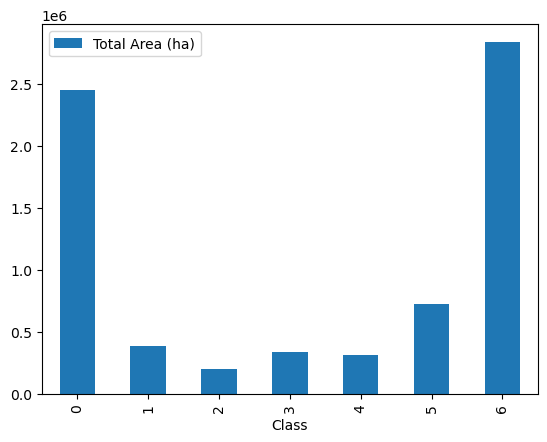

In [229]:
all_consensus_natura_stats.plot(x="Class", y="Total Area (ha)", kind="bar") 